In [2]:
import os
import pydicom
from nilearn import plotting
import nibabel as nib
import numpy as np

class Paciente:
  
  def __init__(self, id_paciente):
        self.id_paciente = id_paciente
        self.estudios = []

  def agregar_estudio(self, estudio):
        self.estudios.append(estudio)




class Estudios():
    def __init__(self, id_paciente, id_estudio, fecha, modalidad, ruta):
        self.id_paciente = id_paciente
        self.id_estudio = id_estudio
        self.fecha = fecha
        self.modalidad = modalidad
        self.__ruta = ruta
        self.nifti_output_path = None  

    @property
    def ruta(self):
        return self.__ruta
    @ruta.setter
    def ruta(self, ruta):
        self.__ruta = ruta
    def __str__(self):
            return f"ID Estudio: {self.id_estudio}, Fecha: {self.fecha}, Modalidad: {self.modalidad}, Ruta: {self.ruta}"  #para que muestre la información organizada
    def anonimizar(self):
            if not os.path.exists(self.ruta):
                print(f"Error: La ruta {self.ruta} no existe.")
                return None
            
            dataset = pydicom.dcmread(self.ruta)

            def person_names_callback(dataset, data_element):
                sensitive_tags = [(0x00100010, 0x00100020), (0x00100010, 0x00100030)]  # Etiquetas sensibles de nombres de pacientes y fecha de nacimiento
                if data_element.tag in sensitive_tags:
                    data_element.value = "anonymous"

            def patient_id_callback(dataset, data_element):
                sensitive_tags = [(0x00100020, 0x00100020)]  # Etiqueta sensible de ID de paciente
                if data_element.tag in sensitive_tags:
                    data_element.value = "id"

            def curves_callback(dataset, data_element):
                if data_element.tag.group & 0xFF00 == 0x5000:
                    del dataset[data_element.tag]

            dataset.walk(person_names_callback)
            dataset.walk(patient_id_callback)
            dataset.walk(curves_callback)

            carpeta_anonimizada = "anonimizada"
            if not os.path.exists(carpeta_anonimizada):
                os.makedirs(carpeta_anonimizada)

            ruta_anonimizada = os.path.join(carpeta_anonimizada, f"imag_{self.id_estudio}.dcm")
            dataset.save_as(ruta_anonimizada)

            print("Datos anonimizados guardados en:", ruta_anonimizada)
            return ruta_anonimizada

    def convertir_a_nifti(self, ruta_anonimizada):
            try:
                dataset = pydicom.dcmread(ruta_anonimizada)
                self.descripcion = dataset.SeriesDescription if 'SeriesDescription' in dataset else 'No disponible'
                self.dimensiones_imagen = dataset.pixel_array.shape

                datos_pixeles = dataset.pixel_array
                if datos_pixeles.ndim == 2:
                    datos_pixeles = datos_pixeles[:, :, np.newaxis]

                affine = np.eye(4)
                imagen_nifti = nib.Nifti1Image(datos_pixeles, affine)
                self.nifti_output_path = os.path.join('nifti_output', f"nifti_{self.id_estudio}.nii")
                os.makedirs(os.path.dirname(self.nifti_output_path), exist_ok=True)
                nib.save(imagen_nifti, self.nifti_output_path)
                print(f"Imagen convertida guardada en: {self.nifti_output_path}")
            except Exception as e:
                print(f"Error al convertir DICOM a NIfTI: {e}")

    def visualizar(self, view_type='ortho'):# como visualizar con nilearn, y las formas en las que lo podemos ver--> los planos o en mosaico
            if self.nifti_output_path:
                try:
                    img = nib.load(self.nifti_output_path)
                    if view_type == 'ortho':
                        plotting.plot_anat(img)
                    elif view_type == 'mosaic':
                        plotting.plot_anat(img, display_mode='mosaic')
                    elif view_type in ['x', 'y', 'z']:
                        plotting.plot_anat(img, display_mode=view_type)
                    plotting.show()
                except Exception as e:
                    print(f"Error al visualizar la imagen NIfTI: {e}")
            else:
                print("Primero debes convertir el archivo DICOM a NIfTI.")

    def obtener_detalles(self):
            try:
                dataset = pydicom.dcmread(self.ruta)
                descripcion = dataset.SeriesDescription if 'SeriesDescription' in dataset else 'No disponible'
                dimensiones = (dataset.Rows, dataset.Columns) if 'Rows' in dataset and 'Columns' in dataset else 'No disponible'
                return {
                    'ID Estudio': self.id_estudio,
                    'Fecha': self.fecha,
                    'Modalidad': self.modalidad,
                    'Descripción': descripcion,
                    'Dimensiones': dimensiones
                }
            except Exception as e:
                return {
                    'ID Estudio': self.id_estudio,
                    'Fecha': self.fecha,
                    'Modalidad': self.modalidad,
                    'Descripción': 'Error al leer el archivo DICOM',
                    'Dimensiones': 'Error al leer el archivo DICOM',
                    'Error': str(e)
                }

class SistemaGestion:
    def __init__(self):
        self.pacientes = {}
   
    def agregar_estudio_paciente(self, id_paciente, id_estudio, fecha, modalidad, ruta):
        estudio= Estudios(id_paciente, id_estudio, fecha, modalidad, ruta)
        if id_paciente in self.pacientes:
            self.pacientes[id_paciente].agregar_estudio(estudio)
        else:
            paciente = Paciente(id_paciente)
            paciente.agregar_estudio(estudio)
            self.pacientes[id_paciente] = paciente

    def eliminar_estudio_paciente(self, id_paciente, ruta):
        if id_paciente in self.pacientes:
            paciente = self.pacientes[id_paciente]
            for estudio in paciente.estudios:
                if estudio.ruta == ruta:
                    paciente.estudios.remove(estudio)
                    print(f"Estudio {ruta} eliminado del paciente {id_paciente}.")
                    return
            print(f"No se encontró el estudio con ID {ruta} para el paciente {id_paciente}.")
        else:
            print(f"No se encontró al paciente con ID {id_paciente} en el sistema.")

    def consultar_estudio(self, id_paciente):
        if id_paciente in self.pacientes:
            estudio = self.pacientes[id_paciente].estudios
            if estudio:
                print(f"Estudios del paciente {id_paciente}:")
                for i in estudio:
                    print(f"Ruta del estudio: {i}")
            else:
                print(f"No se encontraron estudios para el paciente {id_paciente}.")
        else:
            print(f"No se encontró al paciente con ID {id_paciente} en el sistema.")

    def lista_pacientes(self):
        return list(self.pacientes.keys())
    
    def estudios_por_paciente(self):
        for id_paciente, paciente in self.pacientes.items():
            print(f"Paciente ID: {id_paciente}, Número de estudios: {len(paciente.estudios)}")
    






Datos anonimizados guardados en: anonimizada\imag_ID1.dcm
Imagen convertida guardada en: nifti_output\nifti_ID1.nii


c:\Users\lucia\anaconda3\Lib\site-packages\nilearn\plotting\displays\_axes.py:74: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = getattr(ax, type)(
c:\Users\lucia\anaconda3\Lib\site-packages\nilearn\plotting\displays\_axes.py:52: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.axis(self.get_object_bounds())


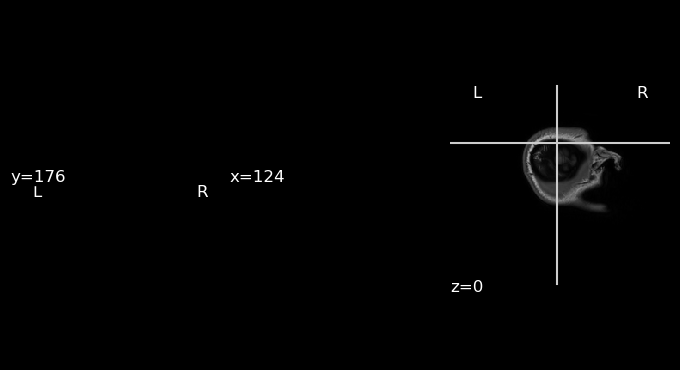

c:\Users\lucia\anaconda3\Lib\site-packages\nilearn\plotting\find_cuts.py:315: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1.
  warnings.warn(


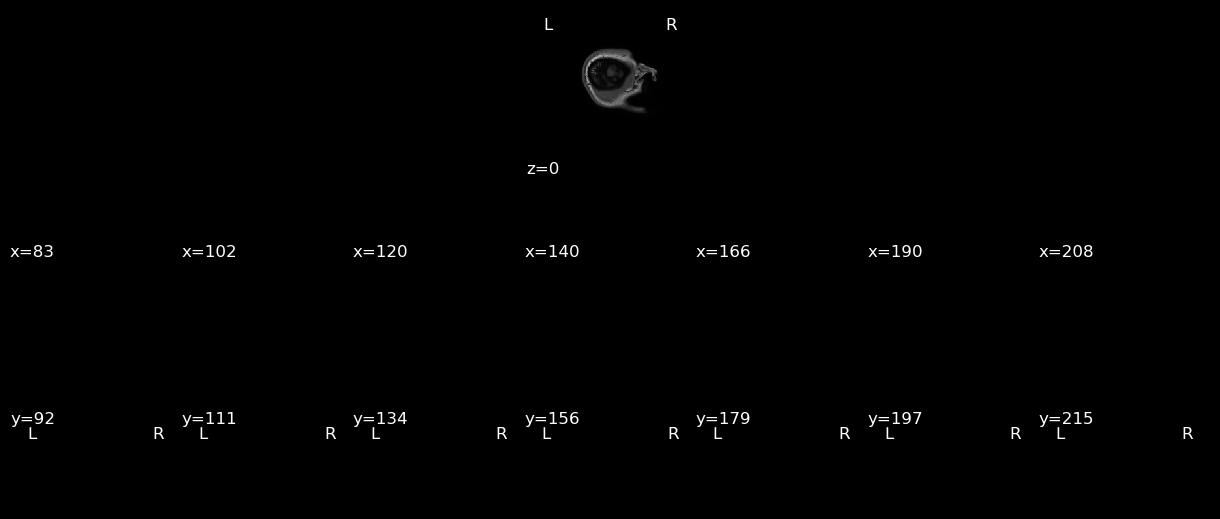

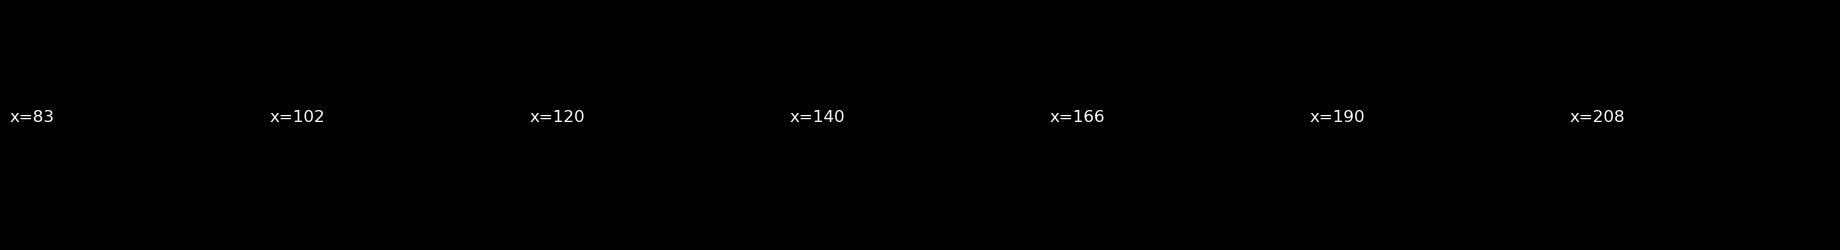

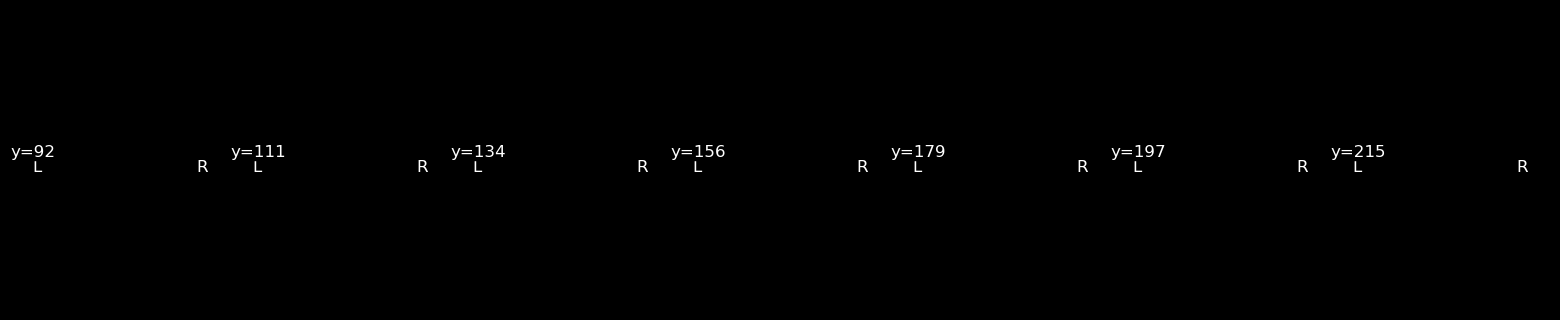

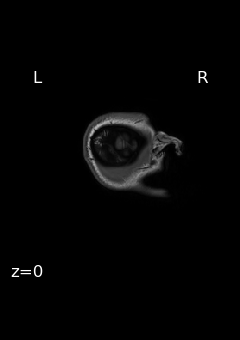

-----------Detalles del estudio--------------
ID Estudio: ID1
Fecha: 20.25.2024
Modalidad: Tomografia
Descripción: SAG_3D_T1_ACCELERATED
Dimensiones: (256, 256)
-----------Detalles del estudio--------------
ID Estudio: ID2
Fecha: 20.25.2024
Modalidad: Ecografía
Descripción: RM cerebro T1
Dimensiones: (235, 205)


In [3]:
sistema = SistemaGestion()

# Agregar estudios para un paciente específico
# Especifica los argumentos adicionales: id_estudio, fecha, modalidad, y ruta para cada estudio
objeto_estudio1 = Estudios(id_paciente="P001", id_estudio="ID1", fecha="20.25.2024", modalidad="Tomografia", ruta=r"C:\Users\lucia\Downloads\jiji\IMG0170.dcm")
objeto_estudio2 = Estudios(id_paciente="P002", id_estudio="ID2", fecha="20.25.2024", modalidad="Ecografía", ruta=r"C:\Users\lucia\Downloads\jiji\IMG0209.dcm")



# Llamar al método convertir_a_nifti
z= objeto_estudio1.anonimizar()
objeto_estudio1.convertir_a_nifti(z)

# Visualizar la imagen NIfTI convertida en diferentes modos
objeto_estudio1.visualizar(view_type='ortho')
objeto_estudio1.visualizar(view_type='mosaic')
objeto_estudio1.visualizar(view_type='x')
objeto_estudio1.visualizar(view_type='y')
objeto_estudio1.visualizar(view_type='z')



# Obtener los detalles del estudio
detalles_estudio1 = objeto_estudio1.obtener_detalles()
detalles_estudio2 = objeto_estudio2.obtener_detalles()


# Imprimir los detalles del estudio
print("-----------Detalles del estudio--------------")
for key, value in detalles_estudio1.items():
    print(f"{key}: {value}")


print("-----------Detalles del estudio--------------")
for key, value in detalles_estudio2.items():
    print(f"{key}: {value}")




In [5]:
sistema.agregar_estudio_paciente("0003", "ID1", "20.25.2024", "Cardiografía", r"C:\Users\lucia\Downloads\jiji\IMG0203.dcm")
sistema.agregar_estudio_paciente("0003", "ID2", "20.25.2024", "Resonancia", r"C:\Users\lucia\Downloads\jiji\IMG0186.dcm")
sistema.agregar_estudio_paciente("0003", "ID3", "20.25.2024", "Tomografía", r"C:\Users\lucia\Downloads\jiji\IMG0174.dcm")

# Consultar los estudios de un paciente
sistema.consultar_estudio("0003")

sistema.eliminar_estudio_paciente("0003", r"C:\Users\lucia\Downloads\jiji\IMG0174.dcm")

sistema.consultar_estudio("0003")

lista_pacientes = sistema.lista_pacientes()
print(lista_pacientes)



Estudios del paciente 0003:
Ruta del estudio: ID Estudio: ID1, Fecha: 20.25.2024, Modalidad: Cardiografía, Ruta: C:\Users\lucia\Downloads\jiji\IMG0203.dcm
Ruta del estudio: ID Estudio: ID2, Fecha: 20.25.2024, Modalidad: Resonancia, Ruta: C:\Users\lucia\Downloads\jiji\IMG0186.dcm
Ruta del estudio: ID Estudio: ID1, Fecha: 20.25.2024, Modalidad: Cardiografía, Ruta: C:\Users\lucia\Downloads\jiji\IMG0203.dcm
Ruta del estudio: ID Estudio: ID2, Fecha: 20.25.2024, Modalidad: Resonancia, Ruta: C:\Users\lucia\Downloads\jiji\IMG0186.dcm
Ruta del estudio: ID Estudio: ID3, Fecha: 20.25.2024, Modalidad: Tomografía, Ruta: C:\Users\lucia\Downloads\jiji\IMG0174.dcm
Estudio C:\Users\lucia\Downloads\jiji\IMG0174.dcm eliminado del paciente 0003.
Estudios del paciente 0003:
Ruta del estudio: ID Estudio: ID1, Fecha: 20.25.2024, Modalidad: Cardiografía, Ruta: C:\Users\lucia\Downloads\jiji\IMG0203.dcm
Ruta del estudio: ID Estudio: ID2, Fecha: 20.25.2024, Modalidad: Resonancia, Ruta: C:\Users\lucia\Downloads\j